<a href="https://colab.research.google.com/github/qianxiaowk/site/blob/main/GIS5122_Final_Project_WeiningKan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -q pymer4==0.7.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.5 MB/s eta 0:00:00


In [ ]:
pip install -q esda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install pandas==1.3.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.3.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
esda 2.5.1 requires pandas>1.4, but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.3.5 which is incompatible.
libpysal 4.10 requires pandas>=1.4, but you have pandas 1.3.5 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
statsmodels 0.14.2 requires pandas!=2.1.0,>=1.4, but you have pandas 1.3.5 which is incompatible.
xarray 2023.7.0 requires pandas>=1.4, but you have pandas 

In [ ]:
!pip install -q Geopandas

In [ ]:
import rpy2.ipython
%load_ext rpy2.ipython

import logging
# Suppress Python warnings for rpy2 callbacks
logging.getLogger('rpy2.rinterface_lib.callbacks').setLevel(logging.ERROR)

In [ ]:
%%time
#This may take a while (~5 mins)
%R install.packages("lme4")
%R install.packages("lmerTest");

CPU times: user 3.79 s, sys: 378 ms, total: 4.17 s
Wall time: 5min 32s


In [ ]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps
from libpysal.weights import Queen
from esda.moran import Moran
from itertools import combinations
from pymer4.models import Lmer

In [ ]:
import os

# **Data preparation**

## PM 2.5 of 2016

In [ ]:
# Data source: Annual average concentration of PM2.5 (1998-2016), ArcGIS Online

PM25_url = "/content/drive/MyDrive/Colab Notebooks/GIS5122_Final/shapefile/Counties.shp"
PM25_all = gpd.read_file(PM25_url)

In [ ]:
PM25_rename = PM25_all.rename(columns={
    'NAME': 'NAME_O',
    'END_DAT_17': 'Avg_PM2.5_2016',
    'homevalue_': 'Avg_Home_Value',
    'Point_Coun': 'Count_of_Points'
})

In [ ]:
PM25_rename['NAME'] = PM25_rename.apply(lambda x: f"{x['NAME_O']}, {x['State']}", axis=1)
PM25_rename[['Avg_Home_Value']] = PM25_rename[['Avg_Home_Value']]/10000

In [ ]:
PM25 = PM25_rename.iloc[:, list(range(0, 6)) + [40, 41, 60] + list(range(63, 67))]
PM25

,COUNTYNS,GEOID,ALAND,AWATER,NAME_O,State,Avg_Home_Value,Count_of_Points,Avg_PM2.5_2016,GlobalID,PM25Weight,geometry,NAME
0,00161526,01001,1.539602e+09,2.570696e+07,Autauga County,Alabama,18.1926,31,9.154197,{c1f6809a-8199-4111-903b-fd0e9aeb3139},12.109411,"POLYGON ((-9619464.597 3856529.258, -9619456.9...","Autauga County, Alabama"
1,00161527,01003,4.117547e+09,1.133056e+09,Baldwin County,Alabama,25.9992,82,7.560826,{07d80579-466a-48b5-a1c3-a3a3a143e913},9.754475,"POLYGON ((-9769972.591 3671426.442, -9769800.1...","Baldwin County, Alabama"
2,00161528,01005,2.292145e+09,5.053870e+07,Barbour County,Alabama,15.5826,47,8.695103,{1d92955f-ece2-49f3-9d0e-377f759b8e04},11.684455,"POLYGON ((-9468394.317 3771591.219, -9468383.2...","Barbour County, Alabama"
3,00161529,01007,1.612167e+09,9.602089e+06,Bibb County,Alabama,14.5147,31,9.037355,{d08a2fc4-3ab2-45ef-8ecd-008a194f2d52},12.488771,"POLYGON ((-9692114.170 3928123.612, -9692005.6...","Bibb County, Alabama"
4,00161530,01009,1.670104e+09,1.501542e+07,Blount County,Alabama,17.1667,34,8.718491,{3ddece88-4916-4e56-b4be-b3660f9982a6},12.372189,"POLYGON ((-9623906.701 4063676.211, -9623890.4...","Blount County, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,01804553,72145,1.187776e+08,5.779502e+07,Vega Baja Municipio,Puerto Rico,0.0000,2,1.395327,{fdef51b1-7436-4bea-90af-cd5329058b28},0.000000,"POLYGON ((-7386008.758 2094552.908, -7386014.4...","Vega Baja Municipio, Puerto Rico"
3216,01804554,72147,1.315414e+08,5.521928e+08,Vieques Municipio,Puerto Rico,0.0000,2,0.682787,{ed6d9fa3-181b-4de9-936f-61ac8e3e12ba},0.000000,"POLYGON ((-7272430.284 2054755.079, -7270662.6...","Vieques Municipio, Puerto Rico"
3217,01804555,72149,9.229857e+07,3.622639e+06,Villalba Municipio,Puerto Rico,0.0000,2,1.172840,{36150aa9-7fe6-4d54-b060-922403781b4a},0.000000,"POLYGON ((-7396574.405 2058238.655, -7396560.0...","Villalba Municipio, Puerto Rico"
3218,01804556,72151,1.430052e+08,7.259252e+07,Yabucoa Municipio,Puerto Rico,0.0000,4,0.815447,{c6b997ff-06d8-4a86-a36a-e66c833656fe},0.000000,"POLYGON ((-7333462.356 2051384.760, -7333461.2...","Yabucoa Municipio, Puerto Rico"


## Land use

In [ ]:
# Data source: https://services8.arcgis.com/O5dJJKQg5b6RjO3d/arcgis/rest/services/Heat_Health_Census_Tract_Summaries_v1/FeatureServer/layers

land_url = "/content/drive/MyDrive/Colab Notebooks/GIS5122_Final/land use/Higher Risk Areas By County.shp"
land_all = gpd.read_file(land_url)

In [ ]:
land_all

,GEOID,State,County,Low_Summer,High_Summe,Summer_Mea,MEAN_PCT_T,MEAN_PCT_L,MEAN_PCT_I,B01001_001,B17020_cal,B08201_cal,geometry
0,48007950100,Texas,Aransas County,86.006317,99.245789,92.741994,9.034360,90.965640,1.590426,5333,13.0,1.9,"MULTIPOLYGON (((-10804252.328 3231473.063, -10..."
1,48007950200,Texas,Aransas County,94.477371,94.477371,94.477371,1.186391,98.813609,51.151642,1085,2.9,3.1,"MULTIPOLYGON (((-10802907.700 3252808.588, -10..."
2,48007950300,Texas,Aransas County,93.451050,95.835266,94.423422,8.732339,91.267661,27.330107,7598,24.9,3.2,"POLYGON ((-10802614.485 3255770.165, -10802614..."
3,48007950400,Texas,Aransas County,93.822113,95.922104,95.287145,3.780924,96.219076,33.473041,4573,28.7,12.6,"POLYGON ((-10803787.124 3251465.050, -10803784..."
4,48007950500,Texas,Aransas County,87.553680,102.680008,95.106421,3.230059,96.769941,5.121369,5873,22.1,4.3,"MULTIPOLYGON (((-10804110.507 3232671.766, -10..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72241,23029955800,Maine,Washington County,59.177498,75.995789,72.151281,63.051785,36.948215,1.145565,2282,17.2,9.1,"MULTIPOLYGON (((-7487831.410 5559762.037, -748..."
72242,23029956100,Maine,Washington County,64.256317,78.458946,74.168973,49.444713,50.555287,1.368412,2332,15.9,6.3,"MULTIPOLYGON (((-7503742.304 5554089.697, -750..."
72243,23029956300,Maine,Washington County,59.007500,82.801056,75.324478,60.943091,39.056909,1.325459,2802,17.7,8.8,"MULTIPOLYGON (((-7528608.407 5533052.974, -752..."
72244,23029956400,Maine,Washington County,57.586250,83.701050,76.117459,61.654901,38.345099,1.674807,3082,16.8,3.9,"MULTIPOLYGON (((-7537683.617 5533434.471, -753..."


In [ ]:
land_re = land_all.rename(columns={
    'Low_Summer': 'low Summer avg temp',
    'High_Summe': 'high Summer avg temp',
    'Summer_Mea': 'summer avg temp',
    'MEAN_PCT_T': 'pct tree canopy',
    'MEAN_PCT_L': 'pct lacking tree canopy',
    'MEAN_PCT_I': 'pct impervious',
    'B01001_001': 'total pop',
    'B08201_cal': 'pct HHs no vehicle'
})

In [ ]:
land_re = land_re.drop('total pop', axis=1)

In [ ]:
land_re

,GEOID,State,County,low Summer avg temp,high Summer avg temp,summer avg temp,pct tree canopy,pct lacking tree canopy,pct impervious,B17020_cal,pct HHs no vehicle,geometry
0,48007950100,Texas,Aransas County,86.006317,99.245789,92.741994,9.034360,90.965640,1.590426,13.0,1.9,"MULTIPOLYGON (((-10804252.328 3231473.063, -10..."
1,48007950200,Texas,Aransas County,94.477371,94.477371,94.477371,1.186391,98.813609,51.151642,2.9,3.1,"MULTIPOLYGON (((-10802907.700 3252808.588, -10..."
2,48007950300,Texas,Aransas County,93.451050,95.835266,94.423422,8.732339,91.267661,27.330107,24.9,3.2,"POLYGON ((-10802614.485 3255770.165, -10802614..."
3,48007950400,Texas,Aransas County,93.822113,95.922104,95.287145,3.780924,96.219076,33.473041,28.7,12.6,"POLYGON ((-10803787.124 3251465.050, -10803784..."
4,48007950500,Texas,Aransas County,87.553680,102.680008,95.106421,3.230059,96.769941,5.121369,22.1,4.3,"MULTIPOLYGON (((-10804110.507 3232671.766, -10..."
...,...,...,...,...,...,...,...,...,...,...,...,...
72241,23029955800,Maine,Washington County,59.177498,75.995789,72.151281,63.051785,36.948215,1.145565,17.2,9.1,"MULTIPOLYGON (((-7487831.410 5559762.037, -748..."
72242,23029956100,Maine,Washington County,64.256317,78.458946,74.168973,49.444713,50.555287,1.368412,15.9,6.3,"MULTIPOLYGON (((-7503742.304 5554089.697, -750..."
72243,23029956300,Maine,Washington County,59.007500,82.801056,75.324478,60.943091,39.056909,1.325459,17.7,8.8,"MULTIPOLYGON (((-7528608.407 5533052.974, -752..."
72244,23029956400,Maine,Washington County,57.586250,83.701050,76.117459,61.654901,38.345099,1.674807,16.8,3.9,"MULTIPOLYGON (((-7537683.617 5533434.471, -753..."


In [ ]:
for index, column_name in enumerate(land_re.columns):
    print(index, column_name)

0 GEOID
1 State
2 County
3 low Summer avg temp
4 high Summer avg temp
5 summer avg temp
6 pct tree canopy
7 pct lacking tree canopy
8 pct impervious
9 B17020_cal
10 pct HHs no vehicle
11 geometry


In [ ]:
land_1 = land_re.iloc[:, [10, 11] + list(range(0,10))]
land_1['NAME'] = land_1.apply(lambda x: f"{x['County']}, {x['State']}", axis=1)
land_1 = land_1.drop(columns=['geometry', 'GEOID', 'State', 'County'])

columns_to_mean = [
    'pct HHs no vehicle',
    'low Summer avg temp',
    'high Summer avg temp',
    'summer avg temp',
    'pct tree canopy',
    'pct lacking tree canopy',
    'pct impervious'
]



# Calculate the mean of the above variables
land = land_1.groupby('NAME').agg({
    **{col: 'mean' for col in columns_to_mean}
}).reset_index()

land

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,NAME,pct HHs no vehicle,low Summer avg temp,high Summer avg temp,summer avg temp,pct tree canopy,pct lacking tree canopy,pct impervious
0,"Abbeville County, South Carolina",10.316667,84.595790,92.773421,88.251309,63.359835,36.640165,1.251780
1,"Acadia Parish, Louisiana",7.850000,86.632633,96.292384,90.855060,15.274434,84.725566,6.738765
2,"Accomack County, Virginia",7.080000,79.793095,88.096842,84.210556,26.824400,73.175600,2.998381
3,"Ada County, Idaho",4.222034,106.136691,112.375139,109.732906,1.116685,98.883315,29.103529
4,"Adair County, Iowa",4.100000,82.819473,88.406316,84.773413,1.914540,98.085460,1.635185
...,...,...,...,...,...,...,...,...
3103,"Yuma County, Arizona",6.161818,123.818802,132.528849,128.526130,0.000495,99.999505,28.089683
3104,"Yuma County, Colorado",4.600000,90.380001,111.829998,104.868041,0.014375,99.985625,0.274110
3105,"Zapata County, Texas",6.133333,97.022105,114.593160,110.799752,1.509397,98.490603,18.615485
3106,"Zavala County, Texas",12.200000,103.714212,114.702148,109.568887,3.043496,96.956504,3.987374


## GDP 2016

In [ ]:
# Data source: Department of Commerce / Bureau of Economic Analysis / Regional Economic Accounts
# https://apps.bea.gov/regional/downloadzip.cfm

gdp_t = '/content/drive/MyDrive/Colab Notebooks/GIS5122_Final/GDP/GDP2016.xlsx'
gdp_all = pd.read_excel(gdp_t)

In [ ]:
gdp_all

,county_id,GeoName,State,County,State Abb.,LineCode,Industry Descriptions,2007.0,2008.0,Percent Change 2008,2016 GDP
0,1001,"Autauga, AL",Alabama,Autauga,AL,1.0,All Industries,1234500.0,1112891.0,-0.098509,1526310.0
1,1003,"Baldwin, AL",Alabama,Baldwin,AL,1.0,All Industries,5283689.0,4997036.0,-0.054252,5496105.0
2,1005,"Barbour, AL",Alabama,Barbour,AL,1.0,All Industries,862038.0,803027.0,-0.068455,742810.0
3,1007,"Bibb, AL",Alabama,Bibb,AL,1.0,All Industries,359073.0,360056.0,0.002738,357831.0
4,1009,"Blount, AL",Alabama,Blount,AL,1.0,All Industries,861808.0,849389.0,-0.014410,783480.0
...,...,...,...,...,...,...,...,...,...,...,...
3111,56037,"Sweetwater, WY",Wyoming,Sweetwater,WY,1.0,All Industries,4467972.0,4631350.0,0.036566,3961894.0
3112,56039,"Teton, WY",Wyoming,Teton,WY,1.0,All Industries,1798927.0,1818868.0,0.011085,2019964.0
3113,56041,"Uinta, WY",Wyoming,Uinta,WY,1.0,All Industries,1236378.0,1272157.0,0.028939,938876.0
3114,56043,"Washakie, WY",Wyoming,Washakie,WY,1.0,All Industries,351274.0,390777.0,0.112456,366053.0


In [ ]:
gdp = gdp_all.rename(columns={
    '2016 GDP': 'GDP_2016'
})

In [ ]:
gdp
gdp1= gdp.iloc[:, [0,10]]

##  American Community Survey 2015-2019 5-year estimate

In [ ]:
# American Community Survey 2015-2019 5-year estimate
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [ ]:
# Merge "County" and "State" into one column
socio_demo[['County', 'State']] = socio_demo['NAME'].str.split(',', expand=True)

socio_demo['County'] = socio_demo['County'].str.strip()
socio_demo['State'] = socio_demo['State'].str.strip()

In [ ]:
socio_demo_re= socio_demo.iloc[:, list(range(0, 4)) + [6, 11, 14, 15, 16]]
socio_demo_re[['median_income']] = socio_demo_re[['median_income']]/10000

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
socio_demo_re

,county_id,state,county,NAME,total_pop,median_income,gini,pct_manuf,ln_pop_den
0,17051,17,51,"Fayette County, Illinois",21565,4.6650,0.4373,14.9,3.392715
1,17107,17,107,"Logan County, Illinois",29003,5.7308,0.4201,12.4,3.847224
2,17165,17,165,"Saline County, Illinois",23994,4.4090,0.4692,8.7,4.128654
3,17097,17,97,"Lake County, Illinois",701473,8.9427,0.4847,16.3,7.308201
4,17127,17,127,"Massac County, Illinois",14219,4.7481,0.4097,7.4,4.067788
...,...,...,...,...,...,...,...,...,...
3098,47033,47,33,"Crockett County, Tennessee",14399,4.4717,0.4459,16.6,3.988597
3099,47095,47,95,"Lake County, Tennessee",7401,3.5191,0.5416,12.5,3.641088
3100,47093,47,93,"Knox County, Tennessee",461104,5.7470,0.4808,7.8,6.776458
3101,53005,53,5,"Benton County, Washington",197518,6.9023,0.4246,7.0,4.720781


## Merge PM2.5, Land Use, GDP and Socio demo

In [ ]:
socio_gdp = gpd.GeoDataFrame(pd.merge(socio_demo_re, gdp1, on='county_id', how='left'))

In [ ]:
PM25_land = gpd.GeoDataFrame(pd.merge(PM25, land, on='NAME', how='left'))

In [ ]:
type(socio_gdp)

geopandas.geodataframe.GeoDataFrame

In [ ]:
socio_PM25_land = gpd.GeoDataFrame(PM25_land.merge(socio_gdp, on = "NAME"))
socio_PM25_land.columns = socio_PM25_land.columns.str.replace(' ', '_')

In [ ]:
# GDPP was derived by dividing county-level GDP by total population data for each county.
socio_PM25_land['GDPP'] = socio_PM25_land['GDP_2016']/socio_PM25_land['total_pop']

In [ ]:
socio_PM25_land

,COUNTYNS,GEOID,ALAND,AWATER,NAME_O,State,Avg_Home_Value,Count_of_Points,Avg_PM2.5_2016,GlobalID,...,county_id,state,county,total_pop,median_income,gini,pct_manuf,ln_pop_den,GDP_2016,GDPP
0,00161526,01001,1.539602e+09,2.570696e+07,Autauga County,Alabama,18.1926,31,9.154197,{c1f6809a-8199-4111-903b-fd0e9aeb3139},...,1001,1,1,55380,5.8731,0.4542,13.0,4.519786,1526310.0,27.560672
1,00161527,01003,4.117547e+09,1.133056e+09,Baldwin County,Alabama,25.9992,82,7.560826,{07d80579-466a-48b5-a1c3-a3a3a143e913},...,1003,1,3,212830,5.8320,0.4587,9.2,4.840380,5496105.0,25.82392
2,00161528,01005,2.292145e+09,5.053870e+07,Barbour County,Alabama,15.5826,47,8.695103,{1d92955f-ece2-49f3-9d0e-377f759b8e04},...,1005,1,5,25361,3.2525,0.4883,23.0,3.327549,742810.0,29.28946
3,00161529,01007,1.612167e+09,9.602089e+06,Bibb County,Alabama,14.5147,31,9.037355,{d08a2fc4-3ab2-45ef-8ecd-008a194f2d52},...,1007,1,7,22493,4.7542,0.4487,16.9,3.585793,357831.0,15.908549
4,00161530,01009,1.670104e+09,1.501542e+07,Blount County,Alabama,17.1667,34,8.718491,{3ddece88-4916-4e56-b4be-b3660f9982a6},...,1009,1,9,57681,4.9358,0.4570,17.2,4.485479,783480.0,13.582982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,01609192,56037,2.700575e+10,1.662303e+08,Sweetwater County,Wyoming,22.0628,548,4.290398,{47c6ba23-7c27-4fef-a50e-6f65dfd4cee6},...,56037,56,37,43521,7.4843,0.4065,6.0,1.422107,3961894.0,91.034076
3099,01605083,56039,1.035178e+10,5.708649e+08,Teton County,Wyoming,101.5732,220,3.179278,{6365d158-640e-432b-9572-a31cd6391bc5},...,56039,56,39,23280,8.4678,0.5003,1.2,1.708401,2019964.0,86.768213
3100,01605084,56041,5.391632e+09,1.662582e+07,Uinta County,Wyoming,23.6455,108,3.933997,{6b3e71f4-3c7b-4deb-bc5f-52ecf33b5f2f},...,56041,56,41,20479,6.3403,0.3861,5.0,2.282293,938876.0,45.845793
3101,01605085,56043,5.798139e+09,1.042960e+07,Washakie County,Wyoming,22.4680,116,3.745067,{02a0366c-0bd8-4468-a44f-cbff56048404},...,56043,56,43,8027,5.4158,0.3868,8.7,1.274724,366053.0,45.602716


In [ ]:
print(socio_PM25_land.isnull().sum())  # Shows the count of NaNs in each column


COUNTYNS                    0
GEOID                       0
ALAND                       0
AWATER                      0
NAME_O                      0
State                       0
Avg_Home_Value              0
Count_of_Points             0
Avg_PM2.5_2016              0
GlobalID                    0
PM25Weight                  0
geometry                    0
NAME                        0
pct_HHs_no_vehicle          0
low_Summer_avg_temp         0
high_Summer_avg_temp        0
summer_avg_temp             0
pct_tree_canopy             0
pct_lacking_tree_canopy     0
pct_impervious              0
county_id                   0
state                       0
county                      0
total_pop                   0
median_income               0
gini                        0
pct_manuf                   0
ln_pop_den                  0
GDP_2016                   40
GDPP                       40
dtype: int64


In [ ]:
median_value_gdp = socio_PM25_land['GDPP'].median()
#median_value_gdp_manuf = socio_PM25_land['GDPP_manuf'].median()

# the distribution is skewed, we  use the median:
socio_PM25_land['GDPP'].fillna(median_value_gdp, inplace=True)
#socio_PM25_land['GDPP_manuf'].fillna(median_value_gdp_manuf, inplace=True)

In [ ]:
socio_PM25_land['proj_X'] = socio_PM25_land.geometry.centroid.x
socio_PM25_land['proj_Y'] = socio_PM25_land.geometry.centroid.y

In [ ]:
socio_PM25_land

,COUNTYNS,GEOID,ALAND,AWATER,NAME_O,State,Avg_Home_Value,Count_of_Points,Avg_PM2.5_2016,GlobalID,...,county,total_pop,median_income,gini,pct_manuf,ln_pop_den,GDP_2016,GDPP,proj_X,proj_Y
0,00161526,01001,1.539602e+09,2.570696e+07,Autauga County,Alabama,18.1926,31,9.154197,{c1f6809a-8199-4111-903b-fd0e9aeb3139},...,1,55380,5.8731,0.4542,13.0,4.519786,1526310.0,27.560672,-9.645027e+06,3.833754e+06
1,00161527,01003,4.117547e+09,1.133056e+09,Baldwin County,Alabama,25.9992,82,7.560826,{07d80579-466a-48b5-a1c3-a3a3a143e913},...,3,212830,5.8320,0.4587,9.2,4.840380,5496105.0,25.823920,-9.765241e+06,3.597575e+06
2,00161528,01005,2.292145e+09,5.053870e+07,Barbour County,Alabama,15.5826,47,8.695103,{1d92955f-ece2-49f3-9d0e-377f759b8e04},...,5,25361,3.2525,0.4883,23.0,3.327549,742810.0,29.289460,-9.505915e+06,3.746244e+06
3,00161529,01007,1.612167e+09,9.602089e+06,Bibb County,Alabama,14.5147,31,9.037355,{d08a2fc4-3ab2-45ef-8ecd-008a194f2d52},...,7,22493,4.7542,0.4487,16.9,3.585793,357831.0,15.908549,-9.698870e+06,3.895148e+06
4,00161530,01009,1.670104e+09,1.501542e+07,Blount County,Alabama,17.1667,34,8.718491,{3ddece88-4916-4e56-b4be-b3660f9982a6},...,9,57681,4.9358,0.4570,17.2,4.485479,783480.0,13.582982,-9.636627e+06,4.026265e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,01609192,56037,2.700575e+10,1.662303e+08,Sweetwater County,Wyoming,22.0628,548,4.290398,{47c6ba23-7c27-4fef-a50e-6f65dfd4cee6},...,37,43521,7.4843,0.4065,6.0,1.422107,3961894.0,91.034076,-1.212035e+07,5.110571e+06
3099,01605083,56039,1.035178e+10,5.708649e+08,Teton County,Wyoming,101.5732,220,3.179278,{6365d158-640e-432b-9572-a31cd6391bc5},...,39,23280,8.4678,0.5003,1.2,1.708401,2019964.0,86.768213,-1.231083e+07,5.455876e+06
3100,01605084,56041,5.391632e+09,1.662582e+07,Uinta County,Wyoming,23.6455,108,3.933997,{6b3e71f4-3c7b-4deb-bc5f-52ecf33b5f2f},...,41,20479,6.3403,0.3861,5.0,2.282293,938876.0,45.845793,-1.230610e+07,5.054937e+06
3101,01605085,56043,5.798139e+09,1.042960e+07,Washakie County,Wyoming,22.4680,116,3.745067,{02a0366c-0bd8-4468-a44f-cbff56048404},...,43,8027,5.4158,0.3868,8.7,1.274724,366053.0,45.602716,-1.198726e+07,5.450874e+06


In [ ]:
# socio_PM25_land.to_csv('/content/drive/MyDrive/Colab Notebooks/GIS5122_Final/merged_data.csv', index=False)



## State

In [ ]:
state = socio_PM25_land.dissolve(by='State', aggfunc='mean')

In [ ]:
print(socio_PM25_land.dtypes)


COUNTYNS                     object
GEOID                        object
ALAND                       float64
AWATER                      float64
NAME_O                       object
State                        object
Avg_Home_Value              float64
Count_of_Points               int64
Avg_PM2.5_2016              float64
GlobalID                     object
PM25Weight                  float64
geometry                   geometry
NAME                         object
pct_HHs_no_vehicle          float64
low_Summer_avg_temp         float64
high_Summer_avg_temp        float64
summer_avg_temp             float64
pct_tree_canopy             float64
pct_lacking_tree_canopy     float64
pct_impervious              float64
county_id                     int64
state                         int64
county                        int64
total_pop                     int64
median_income               float64
gini                        float64
pct_manuf                   float64
ln_pop_den                  

In [ ]:
state

,geometry,ALAND,AWATER,Avg_Home_Value,Count_of_Points,Avg_PM2.5_2016,PM25Weight,pct_HHs_no_vehicle,low_Summer_avg_temp,high_Summer_avg_temp,...,state,county,total_pop,median_income,gini,pct_manuf,ln_pop_den,GDPP,proj_X,proj_Y
State,,,,,,,,,,,,,,,,,,,,,
Alabama,"MULTIPOLYGON (((-9804886.172 3535087.083, -980...",1.957822e+09,6.855712e+07,15.691399,39.850746,8.611069,11.929363,7.266492,85.448777,92.693251,...,1.0,67.000000,72779.850746,4.357485,0.470258,18.526866,3.986613,30.387921,-9.652502e+06,3.880924e+06
Arizona,"POLYGON ((-12406678.697 3691746.741, -12413094...",1.961324e+10,6.848917e+07,22.954007,394.333333,6.362141,5.509548,6.528462,106.070403,123.178255,...,4.0,13.866667,470019.933333,4.898993,0.453393,4.926667,3.036642,40.129429,-1.240799e+07,3.987492e+06
Arkansas,"POLYGON ((-10351644.594 3897621.708, -10351691...",1.796918e+09,3.950479e+07,13.850751,36.906667,7.440079,10.571835,7.038846,86.005187,95.222953,...,5.0,75.000000,39991.600000,4.223671,0.459633,15.966667,3.501829,30.496911,-1.028968e+07,4.152752e+06
California,"MULTIPOLYGON (((-13623981.642 4533950.652, -13...",6.956964e+09,3.528254e+08,51.179629,141.465517,8.316805,8.870602,6.103986,96.984097,112.101538,...,6.0,58.000000,677301.672414,6.771360,0.459398,7.146552,4.569863,55.288824,-1.343938e+07,4.562023e+06
Colorado,"POLYGON ((-11768547.508 4438527.786, -11768895...",4.194108e+09,1.846284e+07,34.605303,83.843750,3.874578,5.395296,4.537835,84.809038,108.650773,...,8.0,62.234375,87661.703125,5.879480,0.440486,4.950000,2.658983,54.290196,-1.174264e+07,4.713702e+06
Connecticut,"MULTIPOLYGON (((-8169032.028 5023688.944, -816...",1.567812e+09,2.269522e+08,33.743150,32.125000,7.528959,9.530048,7.622763,82.738450,87.330382,...,9.0,8.000000,446884.250000,7.920138,0.461025,11.400000,6.267932,56.121639,-8.088203e+06,5.103504e+06
Delaware,"MULTIPOLYGON (((-8429431.984 4697469.141, -842...",1.681975e+09,4.666619e+08,31.373433,35.666667,9.952179,12.906319,6.524181,87.587902,93.558126,...,10.0,3.000000,319082.666667,6.598800,0.445600,8.200000,6.081289,58.700194,-8.408553e+06,4.737584e+06
District of Columbia,"POLYGON ((-8571872.220 4716756.833, -8571767.8...",1.583404e+08,1.868720e+07,76.621300,3.000000,9.944809,13.917146,34.199441,97.930868,98.394585,...,11.0,1.000000,692683.000000,8.642000,0.526900,1.300000,9.224002,172.614799,-8.573417e+06,4.708047e+06
Florida,"MULTIPOLYGON (((-9212348.156 3195565.872, -921...",2.073868e+09,4.680761e+08,24.400434,45.029851,6.288996,9.000707,5.899897,88.140025,95.090003,...,12.0,67.910448,311964.716418,5.129022,0.460139,5.641791,4.946558,30.374030,-9.206019e+06,3.369955e+06


In [ ]:
PM_socio_df = socio_PM25_land.drop(columns='geometry')
PM_socio_df['GDP_2016'] = PM_socio_df['GDP_2016'].astype(float)

In [ ]:
PM_socio_df  # Check current data types

,COUNTYNS,GEOID,ALAND,AWATER,NAME_O,State,Avg_Home_Value,Count_of_Points,Avg_PM2.5_2016,GlobalID,...,county,total_pop,median_income,gini,pct_manuf,ln_pop_den,GDP_2016,GDPP,proj_X,proj_Y
0,00161526,01001,1.539602e+09,2.570696e+07,Autauga County,Alabama,18.1926,31,9.154197,{c1f6809a-8199-4111-903b-fd0e9aeb3139},...,1,55380,5.8731,0.4542,13.0,4.519786,1526310.0,27.560672,-9.645027e+06,3.833754e+06
1,00161527,01003,4.117547e+09,1.133056e+09,Baldwin County,Alabama,25.9992,82,7.560826,{07d80579-466a-48b5-a1c3-a3a3a143e913},...,3,212830,5.8320,0.4587,9.2,4.840380,5496105.0,25.823920,-9.765241e+06,3.597575e+06
2,00161528,01005,2.292145e+09,5.053870e+07,Barbour County,Alabama,15.5826,47,8.695103,{1d92955f-ece2-49f3-9d0e-377f759b8e04},...,5,25361,3.2525,0.4883,23.0,3.327549,742810.0,29.289460,-9.505915e+06,3.746244e+06
3,00161529,01007,1.612167e+09,9.602089e+06,Bibb County,Alabama,14.5147,31,9.037355,{d08a2fc4-3ab2-45ef-8ecd-008a194f2d52},...,7,22493,4.7542,0.4487,16.9,3.585793,357831.0,15.908549,-9.698870e+06,3.895148e+06
4,00161530,01009,1.670104e+09,1.501542e+07,Blount County,Alabama,17.1667,34,8.718491,{3ddece88-4916-4e56-b4be-b3660f9982a6},...,9,57681,4.9358,0.4570,17.2,4.485479,783480.0,13.582982,-9.636627e+06,4.026265e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,01609192,56037,2.700575e+10,1.662303e+08,Sweetwater County,Wyoming,22.0628,548,4.290398,{47c6ba23-7c27-4fef-a50e-6f65dfd4cee6},...,37,43521,7.4843,0.4065,6.0,1.422107,3961894.0,91.034076,-1.212035e+07,5.110571e+06
3099,01605083,56039,1.035178e+10,5.708649e+08,Teton County,Wyoming,101.5732,220,3.179278,{6365d158-640e-432b-9572-a31cd6391bc5},...,39,23280,8.4678,0.5003,1.2,1.708401,2019964.0,86.768213,-1.231083e+07,5.455876e+06
3100,01605084,56041,5.391632e+09,1.662582e+07,Uinta County,Wyoming,23.6455,108,3.933997,{6b3e71f4-3c7b-4deb-bc5f-52ecf33b5f2f},...,41,20479,6.3403,0.3861,5.0,2.282293,938876.0,45.845793,-1.230610e+07,5.054937e+06
3101,01605085,56043,5.798139e+09,1.042960e+07,Washakie County,Wyoming,22.4680,116,3.745067,{02a0366c-0bd8-4468-a44f-cbff56048404},...,43,8027,5.4158,0.3868,8.7,1.274724,366053.0,45.602716,-1.198726e+07,5.450874e+06


# **Pre-processing: VIF**
## Variance inflation factor (VIF) was performed to examine the multi-collinearity of variables, since multi-collinearity will affect the model performance and further the conclusions. VIF quantifies how much the variance is inflated, and each of the predictors has such a factor.

After examining the VIFs for all selected predictor variables, 6 out of 11 have VIFs lower than 10, most of which are below 4.

pct_HHs_no_vehicle  
pct_tree_canopy
pct_impervious
median_income
pct_manuf
GDPP

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


variables = PM_socio_df[['pct_HHs_no_vehicle', 'low_Summer_avg_temp', 'high_Summer_avg_temp' ,'summer_avg_temp','pct_tree_canopy',
       'pct_lacking_tree_canopy', 'pct_impervious', 'median_income', 'gini', 'pct_manuf',
       'ln_pop_den','GDPP']]

def calculate_vif(dataframe):
    # Initialize the DataFrame vif_data to store VIF scores.
    vif_data = pd.DataFrame()
    vif_data["variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Continue the loop until the VIF values of all variables are less than 10.
max_vif = 10
while True:
    vif_data = calculate_vif(variables)
    max_vif_value = vif_data['VIF'].max()
    if max_vif_value < max_vif:
        break
    # remove the highest one
    variables = variables.drop(columns=[vif_data.sort_values('VIF', ascending=False)['variable'].values[0]])

print(vif_data)


             variable       VIF
0  pct_HHs_no_vehicle  4.125515
1     pct_tree_canopy  2.713029
2      pct_impervious  2.520115
3       median_income  4.904882
4           pct_manuf  3.772192
5                GDPP  1.013731


# **Method: Multi-leve Model**
* For model 1, the VPC value calculated by dividing the intercept by the sum of intercept and residual, giving a value of 76.1%, which indicates that 76.1% of the variance in PM2.5 concentrations can be attributed to the fact of 48 states included in the analysis.
* The application of the second model, which considers the predictor variables, further lowers the random part of the intercept from 3.515 to 3.178, suggesting that the adding these variables contribute to the variability of PM2.5 across the states.

## **Model 1: Fit an MLM with varying intercept only (no Xs)**

In [ ]:
model_1 = Lmer('Avg_PM2.5_2016 ~ 1 + (1|state)', data = PM_socio_df)

In [ ]:
model_1.fit()

Formula: Avg_PM2.5_2016~1+(1|state)

Family: gaussian	 Inference: parametric

Number of observations: 3103	 Groups: {'state': 48.0}

Log-likelihood: -4713.188 	 AIC: 9426.376

Random effects:

                 Name    Var    Std
state     (Intercept)  3.515  1.875
Residual               1.131  1.064

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.813,6.278,7.347,0.273,46.303,24.983,0.0,***


In [ ]:
VPC: 0.7614


## **Model 2: Fit an MLM with varying intercept and your independent variables as fixed effects**

In [ ]:
model_2 = Lmer('Avg_PM2.5_2016 ~ 1 + pct_HHs_no_vehicle + pct_tree_canopy + pct_impervious + median_income + pct_manuf + GDPP + (1|state)', data = PM_socio_df)
model_2.fit()

Formula: Avg_PM2.5_2016~1+pct_HHs_no_vehicle+pct_tree_canopy+pct_impervious+median_income+pct_manuf+GDPP+(1|state)

Family: gaussian	 Inference: parametric

Number of observations: 3103	 Groups: {'state': 48.0}

Log-likelihood: -4318.525 	 AIC: 8637.050

Random effects:

                 Name    Var    Std
state     (Intercept)  3.180  1.783
Residual               0.858  0.926

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.365,4.796,5.935,0.290,73.064,18.470,0.000,***
pct_HHs_no_vehicle,0.027,0.015,0.040,0.006,3081.024,4.324,0.000,***
pct_tree_canopy,-0.016,-0.019,-0.014,0.001,3088.103,-12.690,0.000,***
pct_impervious,0.018,0.014,0.022,0.002,3056.229,9.244,0.000,***
median_income,0.177,0.143,0.210,0.017,3074.718,10.328,0.000,***
pct_manuf,0.044,0.038,0.050,0.003,3067.842,13.984,0.000,***
GDPP,-0.000,-0.000,0.000,0.000,3048.982,-1.060,0.289,


## **Model 3: Fit an MLM with varying intercept and both fixed and random effect for your independent variables**

In [ ]:
# Find the best model formula for model 3

# pct_HHs_no_vehicle + pct_tree_canopy + pct_impervious + median_income + pct_manuf + GDPP

from itertools import combinations

random_effects = ['pct_HHs_no_vehicle', 'pct_tree_canopy', 'pct_impervious', 'median_income', 'pct_manuf', 'GDPP']

# Record best aic and model formula
best_aic = np.inf
best_model_formula = None


# Iterate all possible combinations of random effect variables
for i in range(1, len(random_effects)+1):
    for combo in combinations(random_effects, i):
        # Construct a model formula that includes all random effects in the combination.
        random_effects_formula = ' + '.join(combo)
        formula = f'Avg_PM2.5_2016 ~ 1 + pct_HHs_no_vehicle + pct_tree_canopy + pct_impervious + median_income + pct_manuf + GDPP + (1 + {random_effects_formula} | state)'

        # Fit model
        model = Lmer(formula, data=PM_socio_df)
        model.fit()
        model_aic = model.AIC

        # Update the best one
        if model_aic < best_aic:
            best_aic = model_aic
            best_model_formula = formula
            print(f"New best model with {random_effects_formula} as random effect: AIC = {model_aic}")


print("Best Model Formula:", best_model_formula)
print("Best Model AIC:", best_aic)


Formula: Avg_PM2.5_2016~1+pct_HHs_no_vehicle+pct_tree_canopy+pct_impervious+median_income+pct_manuf+GDPP+(1+pct_HHs_no_vehicle|state)

Family: gaussian	 Inference: parametric

Number of observations: 3103	 Groups: {'state': 48.0}

Log-likelihood: -4310.444 	 AIC: 8620.888

Random effects:

                        Name    Var    Std
state            (Intercept)  3.497  1.870
state     pct_HHs_no_vehicle  0.002  0.043
Residual                      0.845  0.919

               IV1                 IV2   Corr
state  (Intercept)  pct_HHs_no_vehicle -0.423

Fixed effects:

New best model with pct_HHs_no_vehicle as random effect: AIC = 8620.887703572753
Formula: Avg_PM2.5_2016~1+pct_HHs_no_vehicle+pct_tree_canopy+pct_impervious+median_income+pct_manuf+GDPP+(1+pct_tree_canopy|state)

Family: gaussian	 Inference: parametric

Number of observations: 3103	 Groups: {'state': 48.0}

Log-likelihood: -3979.469 	 AIC: 7958.938

Random effects:

                     Name    Var    Std
state         (Int

In [ ]:
warnings.filterwarnings('ignore')

model_3 = Lmer('Avg_PM2.5_2016 ~ 1 + pct_HHs_no_vehicle + pct_tree_canopy + pct_impervious + median_income + pct_manuf + GDPP + (1 +  pct_HHs_no_vehicle + pct_tree_canopy + pct_impervious + median_income + pct_manuf|state)', data = PM_socio_df)

model_3.fit()

Model failed to converge with max|grad| = 0.108205 (tol = 0.002, component 1) 

Formula: Avg_PM2.5_2016~1+pct_HHs_no_vehicle+pct_tree_canopy+pct_impervious+median_income+pct_manuf+GDPP+(1+pct_HHs_no_vehicle+pct_tree_canopy+pct_impervious+median_income+pct_manuf|state)

Family: gaussian	 Inference: parametric

Number of observations: 3103	 Groups: {'state': 48.0}

Log-likelihood: -3849.664 	 AIC: 7699.328

Random effects:

                        Name    Var    Std
state            (Intercept)  5.792  2.407
state     pct_HHs_no_vehicle  0.004  0.060
state        pct_tree_canopy  0.003  0.051
state         pct_impervious  0.001  0.028
state          median_income  0.055  0.234
state              pct_manuf  0.001  0.029
Residual                      0.567  0.753

                      IV1                 IV2   Corr
state         (Intercept)  pct_HHs_no_vehicle -0.436
state         (Intercept)     pct_tree_canopy -0.484
state         (Intercept)      pct_impervious  0.146
state         (In

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.002,5.233,6.771,0.392,42.625,15.304,0.000,***
pct_HHs_no_vehicle,0.020,-0.003,0.042,0.011,21.091,1.732,0.098,.
pct_tree_canopy,-0.019,-0.034,-0.003,0.008,15.573,-2.350,0.032,*
pct_impervious,0.012,0.002,0.021,0.005,37.007,2.433,0.020,*
median_income,0.126,0.048,0.204,0.040,26.647,3.173,0.004,**
pct_manuf,0.031,0.020,0.042,0.006,30.259,5.554,0.000,***
GDPP,-0.000,-0.000,0.000,0.000,2856.320,-0.387,0.698,


In [ ]:
def r_square(model):
    var_a = np.sum(model.ranef_var.Var[:-1]) #Sum of variances from random effects
    var_e = model.ranef_var.Var[-1] #Error variance
    var_f = np.sum(model.design_matrix*model.coefs.Estimate,axis=1).var() #Sum of variances from fixed effects

    marginal = var_f/(var_f+var_a+var_e)

    conditional = (var_f+var_a)/(var_f+var_a+var_e)

    print("marginal R2:",marginal)
    print("conditional R2:",conditional)
    return


In [ ]:
r_square(model_1)

marginal R2: 1.6982853964347976e-31
conditional R2: 0.7565772167013111


In [ ]:
r_square(model_2)

marginal R2: 0.09008301612982478
conditional R2: 0.8067152997717562


In [ ]:
r_square(model_3)

marginal R2: 0.047139451685429656
conditional R2: 0.9159056044019984


# **Overview of Spatial Variation**
## The following figures show the distribution of PM2.5 concentration by county and by state for target year 2016. The state-level PM2.5 data are obtained by averaging all the county-level data points within each state.  
* From county-level point of view, the spots with the highest PM2.5 level are distributed in the coastal regions in the southwest US and mainly in California, and it is overall higher in the mid-west and east coast compared to the regions with lower population density, such as the mountain areas and far north.
* Ohio, Indiana, and Delaware are the states with the highest PM2.5 level.


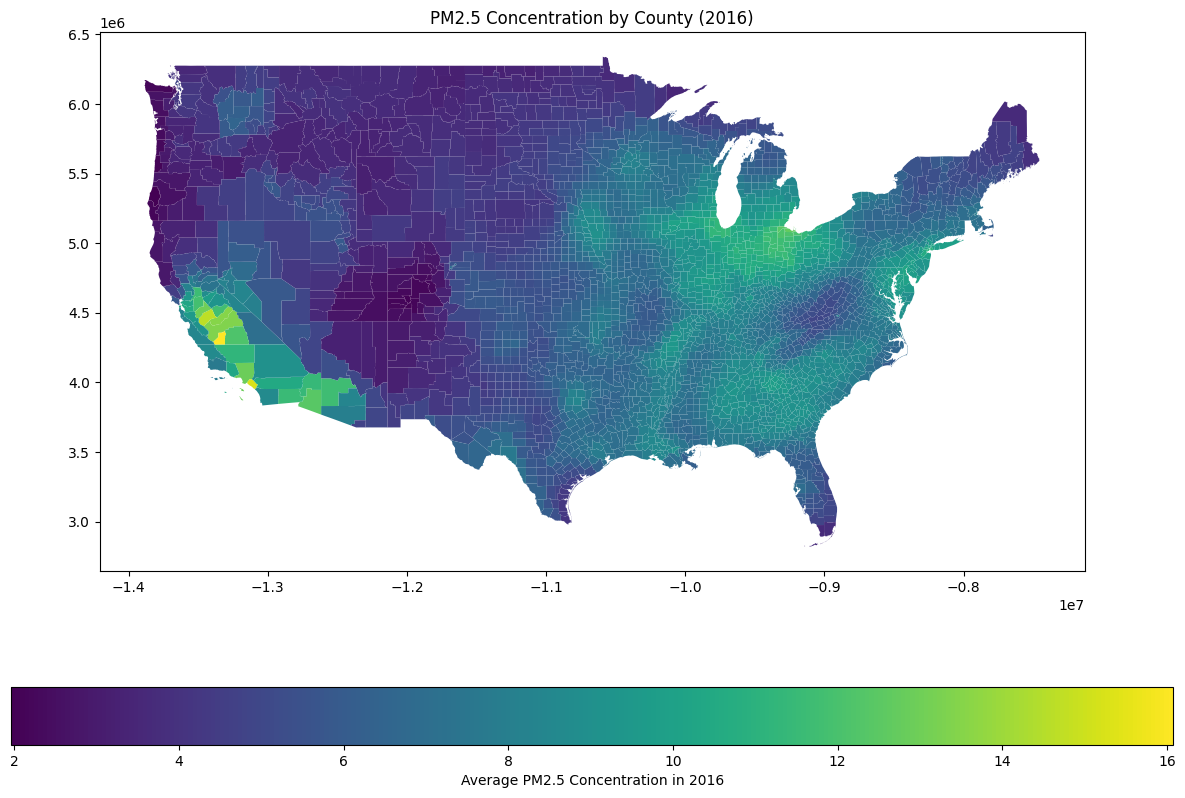

In [ ]:
# PM2.5 by County
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
socio_PM25_land.plot(column='Avg_PM2.5_2016', ax=ax, legend=True,
         legend_kwds={'label': "Average PM2.5 Concentration in 2016", 'orientation': "horizontal"})
plt.title('PM2.5 Concentration by County (2016)')
plt.show()

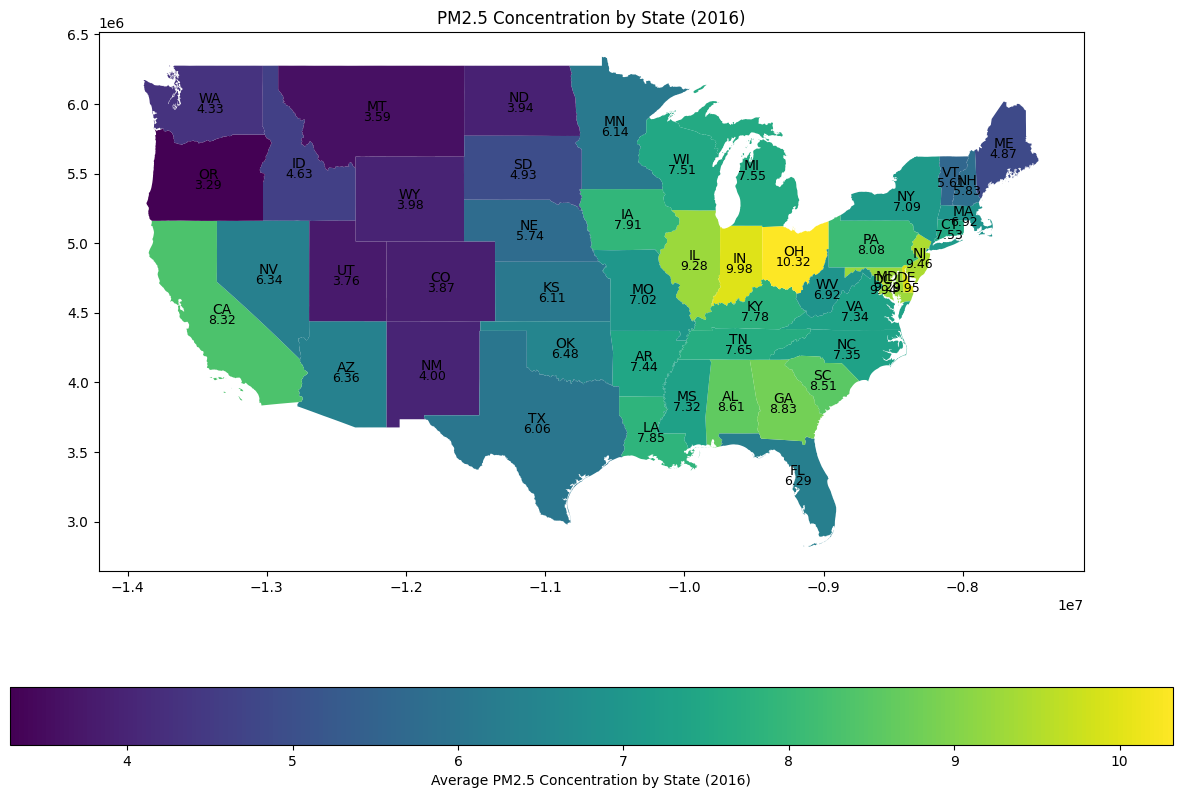

In [ ]:
# PM2.5 by State

# Set the centroid of each state
state['centroid'] = state.geometry.centroid

# State abbreviate
state_abbrev = {
    'Alabama': 'AL', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Mapping
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

state.plot(column='Avg_PM2.5_2016', ax=ax, legend=True,
           legend_kwds={'label': "Average PM2.5 Concentration by State (2016)",
                        'orientation': "horizontal"})
# Fill the state name into the map
for idx, row in state.iterrows():
    state_abbr = state_abbrev.get(idx, 'Unknown')
    plt.text(s=state_abbr, x=row['centroid'].x, y=row['centroid'].y,
             horizontalalignment='center', fontsize=10)
    plt.text(s=f"{row['Avg_PM2.5_2016']:.2f}", x=row['centroid'].x,
             y=row['centroid'].y - 0.2, horizontalalignment='center',
             verticalalignment='top', fontsize=9)

plt.title('PM2.5 Concentration by State (2016)')
plt.show()


# **Final Comparison**
## **Compare AIC, conditional and marginal R2 in three models.**

To better compare the performance of all three models, we introduce the following parameters: the **Akaike information criterion** (AIC, which is an estimation for model quality relative to each of the other models),** marginal R2** as well as conditional R2. Marginal R2 only considers the variance of fixed effects whereas **conditional R2** deals with both fixed and random effects.    

The table below presents the three parameters for the models. Lower AIC values typically point to a better-fit model, and within our expectation model 3 results in the lowest AIC among all three models. In terms of marginal R2, the value of model 3 is the lowest, indicating that fixed factors alone cannot explain much of the variation in PM2.5 concentrations. Also, the increase in conditional R2 from model 1 to model 3 suggests including random slopes in model 3 better captures the data's hierarchical structure than the first two model do.   

In conclusion, **model 3 has the best performance** in terms of best explaining the variations in PM2.5 across the states, given the size and properties of the dataset we have collected.

In [ ]:
model_1.AIC

9426.375648861911

In [ ]:
model_2.AIC

8637.05027234133

In [ ]:
model_3.AIC

7699.327835851464

In [ ]:
data = {
    'Model': ['Model_1', 'Model_2', 'Model_3'],
    'AIC': [9426.376, 8637.050, 7699.327],
    'Marginal R2': [0.000, 0.090, 0.047],
    'Conditional R2': [0.756, 0.806, 0.915]
}

df = pd.DataFrame(data)

df.set_index('Model')

df

,Model,AIC,Marginal R2,Conditional R2
0,Model_1,9426.376,0.000,0.756
1,Model_2,8637.050,0.090,0.806
2,Model_3,7699.327,0.047,0.915


# **Interpretation of Model 3 Output**


## **The impacts of predictor variables on state-level variation in PM2.5 by plotting histograms.**

We can see the most concentrated distribution in percentage of tree canopy, i.e., more than half of all 48 states have the value very close to 0, indicating this variable has similar impact on most of the states. In contrast, the percentage of people working in the manufacturing sector has the widest range of distribution, indicating the state-varying effect of this variable.

array([[<Axes: title={'center': '(Intercept)'}>,
        <Axes: title={'center': 'pct_HHs_no_vehicle'}>],
       [<Axes: title={'center': 'pct_tree_canopy'}>,
        <Axes: title={'center': 'pct_impervious'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'pct_manuf'}>]], dtype=object)

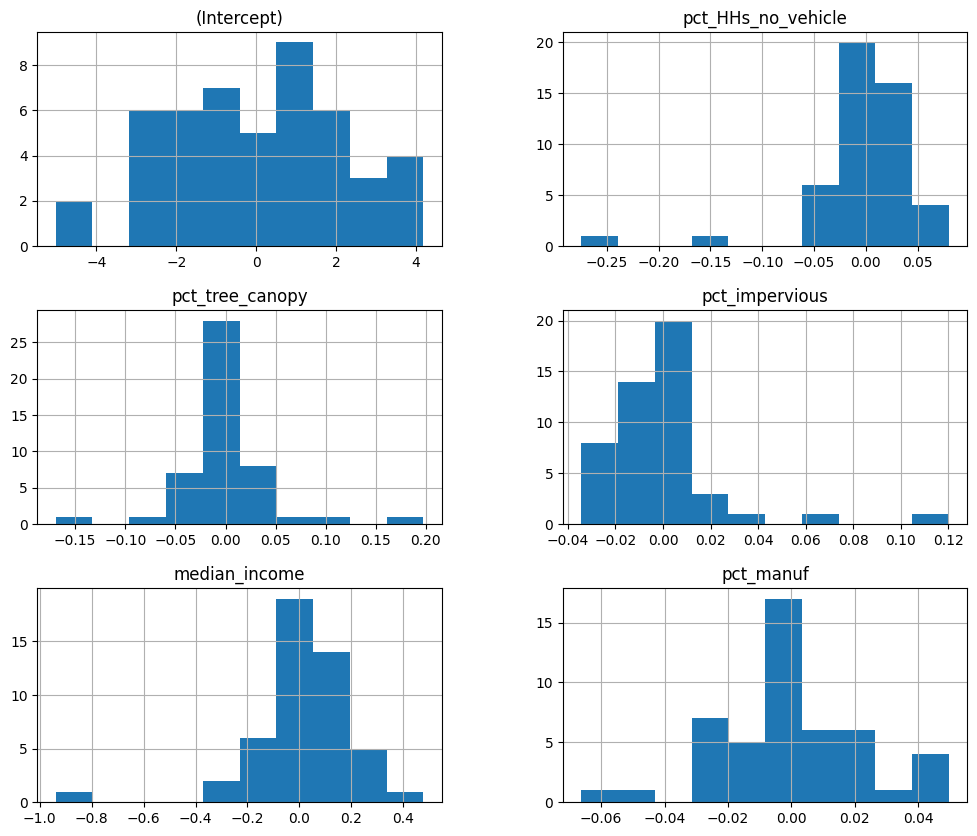

In [ ]:
model_3.ranef.hist(figsize=(12,10))

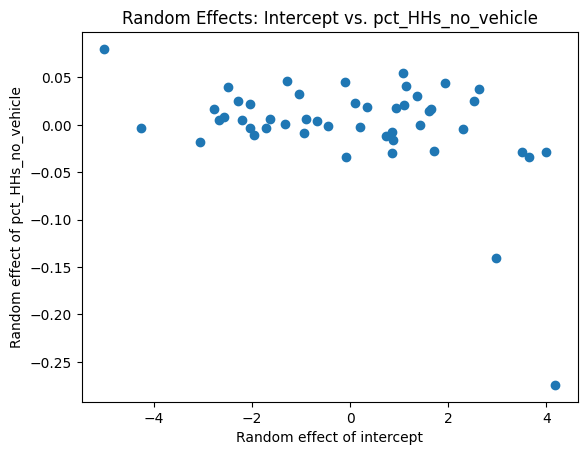

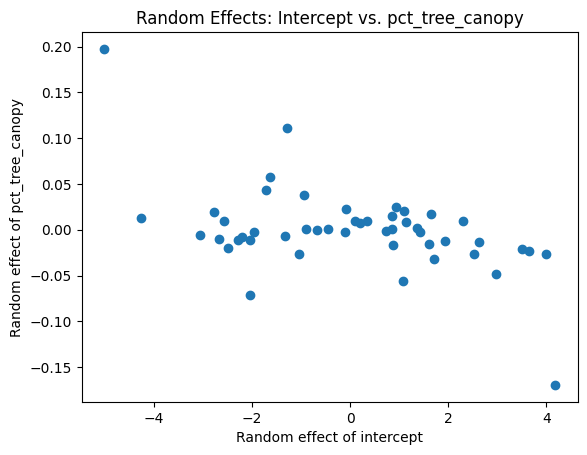

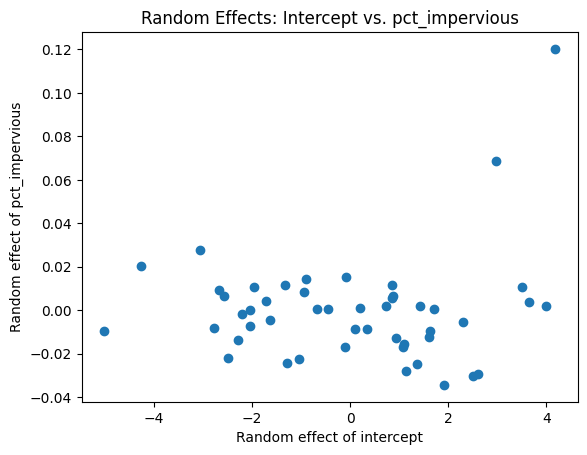

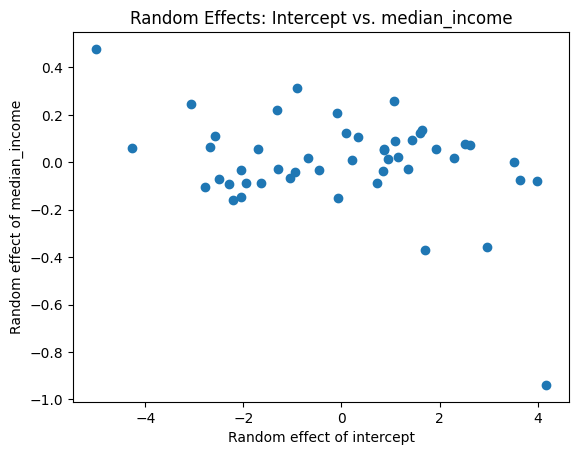

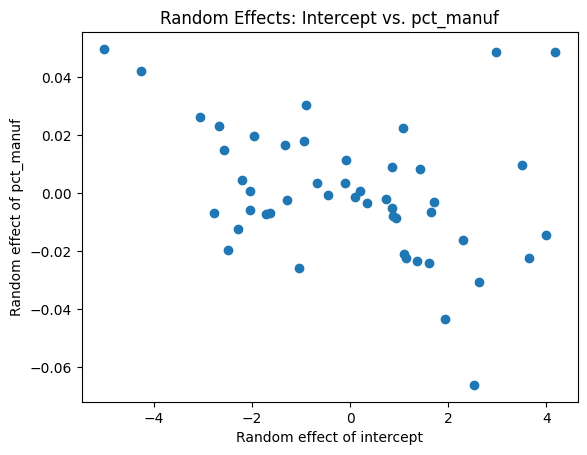

In [ ]:
variables = ['pct_HHs_no_vehicle', 'pct_tree_canopy', 'pct_impervious', 'median_income', 'pct_manuf']
for i, var in enumerate(variables, start=1):
    plt.figure()
    plt.scatter(model_3.ranef.iloc[:, 0], model_3.ranef.iloc[:, i])
    plt.xlabel("Random effect of intercept")
    plt.ylabel(f"Random effect of {var}")
    plt.title(f"Random Effects: Intercept vs. {var}")
    plt.show()


## **Distribution of Random Effects across the States**

The detailed information on the state-wise spatial distribution of 3 selected variables: percentage of households with no vehicle, percentage of impervious surfaces and percentage of people working in the manufacturing sector.

**Percentage of households with no vehicle:** California and Arizona are the two states with most significant negative effects from this variable, indicating the percentage of no-vehicle households are contributing more to the decrease in PM2.5 than to the other states. In other words, in most of the other 46 states PM2.5 level is not quite sensitive to the occupation of vehicles. There exist a few states with positive values such as Nebraska, which is counter-intuitive because lower percentage of vehicle occupation would more likely result in traffic-related PM2.5 emission. Therefore, some more in-depth study is needed to further investigate the correlation between traffic and PM2.5 concentration.

**Percentage of impervious surfaces:** California and Arizona also stand out. For Arizona state, the percentage of impervious surfaces exhibits a strong positive contribution to PM2.5, indicating the predominant role of this variable. It is also worth noting that many states, mostly in the northwest and southeast part of the US present negative correlation between the percentage and PM2.5 level. Current analysis failed to provide an explanation for this correlation and further investigation is needed.

**Percentage of people working in the manufacturing sector:** An overall positive correlation between PM2.5 and percentage of people working in the manufacturing sector in more than half of the states, especially in the west part of the US, such as California, Arizona, and Utah. In general, the percentage is correlated with the development of manufacturing industry, which has long been proven to contribute significantly to the emissions of particulate matter.

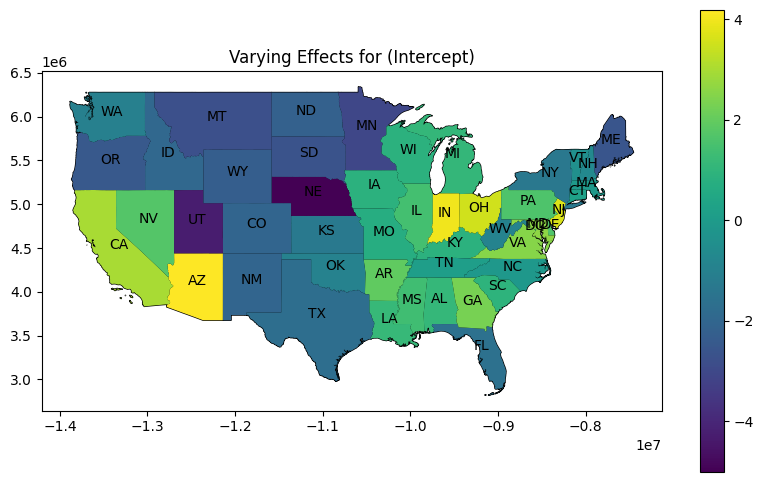

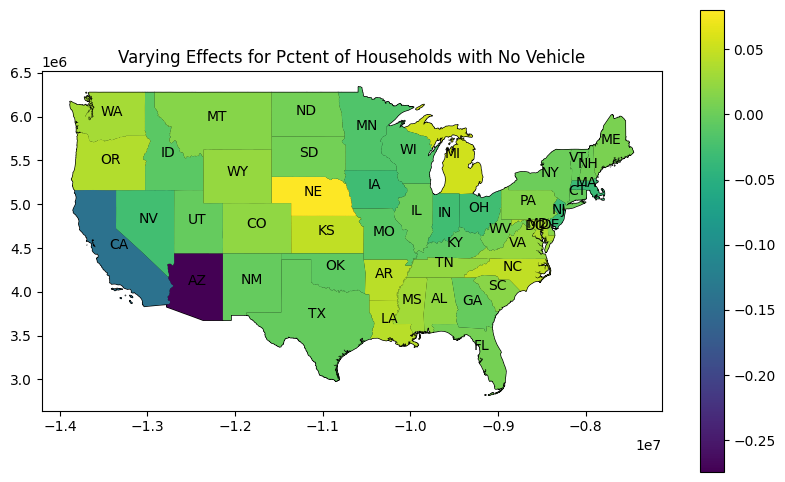

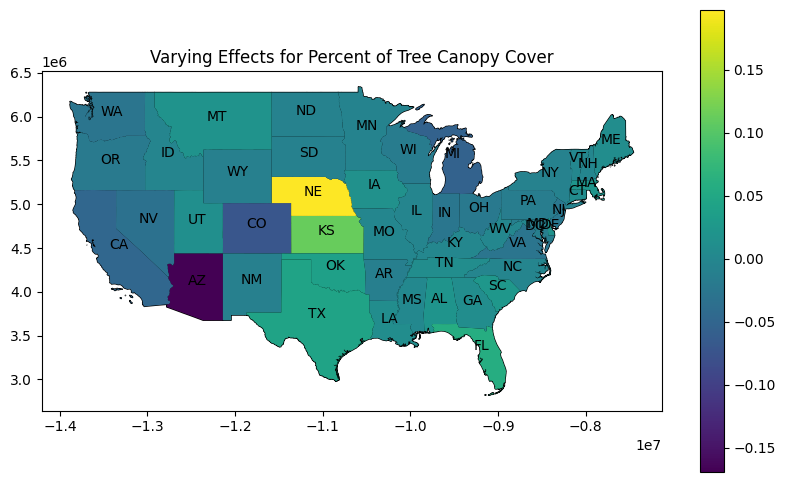

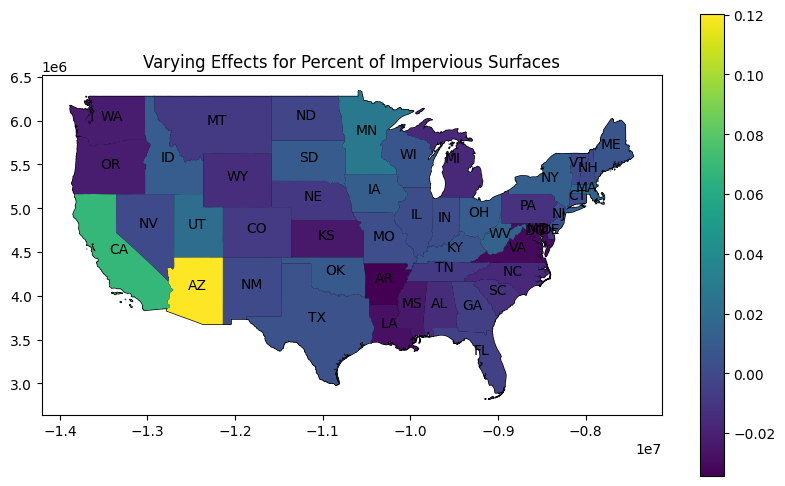

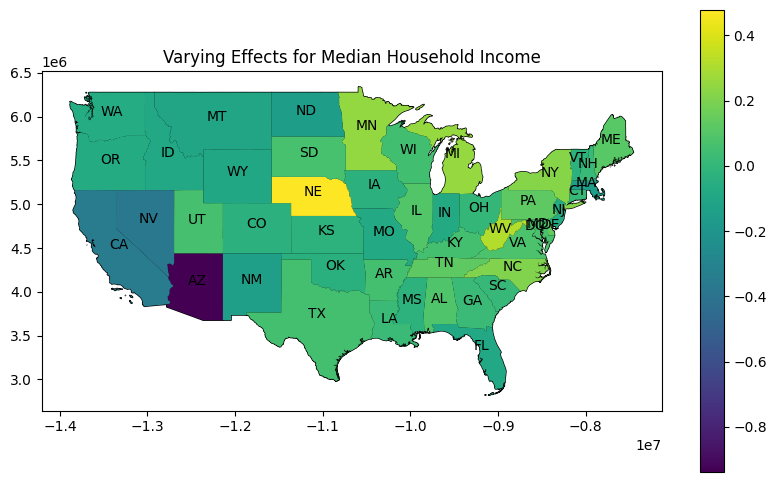

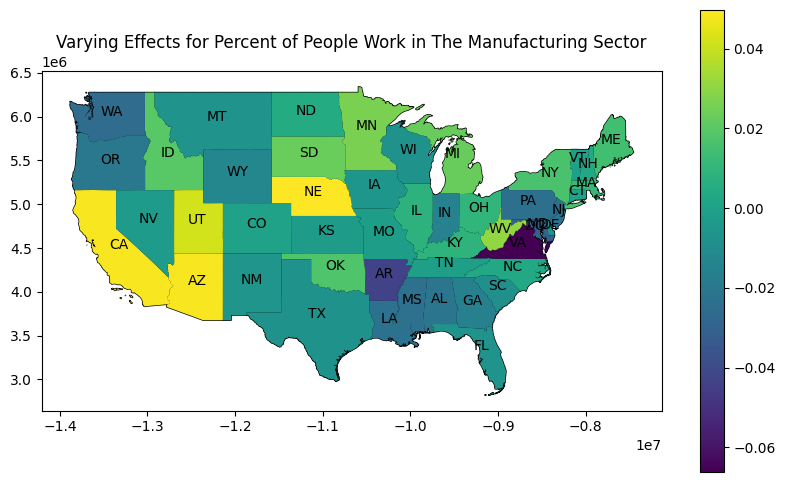

In [ ]:
# model_3 is a fitted model，model_3.ranef is a random effects DataFrame

state_abbrev = {
    'Alabama': 'AL', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Change the name of the columns
column_titles = {
    "X.Intercept": "X.Intercept",
    "pct_HHs_no_vehicle": "Pctent of Households with No Vehicle",
    "pct_tree_canopy": "Percent of Tree Canopy Cover",
    "pct_impervious": "Percent of Impervious Surfaces",
    "median_income": "Median Household Income",
    "pct_manuf": "Percent of People Work in The Manufacturing Sector",
    "GDPP": "GDP per Capita"
}

# Loop every columns in the model_3.ranef
for column in model_3.ranef.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    state.plot(ax=ax, color='whitesmoke', edgecolor='black')

    # Tittle
    friendly_title = column_titles.get(column, column)

    # Mapping
    state.plot(column=model_3.ranef[column].values, ax=ax, legend=True)

    for idx, row in state.iterrows():
        state_abbr = state_abbrev.get(idx, 'Unknown')
        plt.text(s=state_abbr, x=row['centroid'].x, y=row['centroid'].y,
                 horizontalalignment='center', fontsize=10)

    plt.title(f"Varying Effects for {friendly_title}")
    plt.show()
